# Near Surface Air Temperature Quantile Notebook
This notebook looks at how the high quantiles for near surface air temperature vary with longwave optical depth ($CO_2$ concentration proxy) on an aquaplanet.

It is the same as `quantile_notebook.ipynb` except that it uses near surface air temperature (temperature at lowest pressure level recorded) rather than surface temperature.

The conclusions remain the same as with that notebook.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os

2023-03-29 10:32:39,843 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'olr', 'swdn_toa', 'ps', 't_surf']
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Spin up
The net flux converges towards zero if the [actual surface pressure](https://jduffield65.github.io/Isca/namelists/main/spectral_dynamics/#ps) is used to [compute](https://jduffield65.github.io/Isca/code/utils/radiation/#isca_tools.utils.radiation.frierson_net_toa_sw_dwn) the net shortwave radiation at the top of the atmosphere.

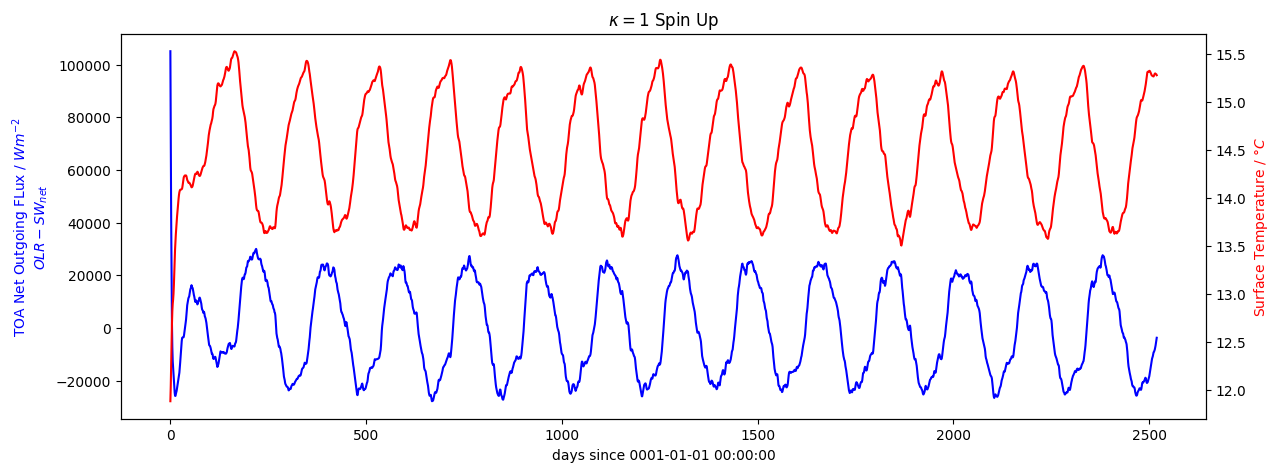

In [3]:
# Plot spin up time
spin_up_ind = np.where(np.asarray(tau_lw)==1)[0][0]     # Use dataset with earthlike optical depth for spin up plot
fig, ax = plt.subplots(1,1, figsize=(14, 5))
isca_tools.plot.plot_spin_up(ds[spin_up_ind].olr, frierson_net_toa_sw_dwn(ds[spin_up_ind].swdn_toa, ds[spin_up_ind].ps,
                                                                          albedo[spin_up_ind], tau_sw[spin_up_ind]),
                             ds[spin_up_ind].t_surf, ax)
plt.title('$\kappa = 1$ Spin Up');

## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [14]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 30
# lat_max = 60
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90

temp_av = np.zeros(n_exp)
ds_temp = []    # near surface temperature for each optical depth value
for i in tqdm(range(n_exp)):
    # only keep air temperature nearest surface and in converged time period
    ds_use = ds[i].sel(time=slice(use_time_start, np.inf)).temp[:, 0]       # [:, 0] to get rid of pressure coordinate
    ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

    if season == 'summer':
        # Only consider summer as has expected circulation
        ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
        ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
        # Combine hemispheres and average over longitude, time and latitude.
        # Note that April, May, June, October, November and December will not be included in this dataset
        ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
    ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
    ds_temp += [ds_use.load()]
    if season == 'summer':
        # Get rid of nan values corresponding to the winter hemisphere - half the values are nan
        ds_temp[i] = ds_temp[i].sel(lon_lat_time =
                                    ds_temp[i].lon_lat_time[np.invert(np.isnan(ds_temp[i]))].to_numpy())
    temp_av[i] = area_weighting(ds_temp[i]).mean(dim=['lon_lat_time'])

 25%|██▌       | 2/8 [00:08<00:24,  4.02s/it]

KeyboardInterrupt



In [ ]:
# Compute quantile near surface temperature across longitude, latitude and time dimension
quantiles = [90, 99, 99.9, 99.99]
n_quant = len(quantiles)
temp_quant = np.zeros((n_exp, n_quant))
with tqdm(total=n_exp * n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(n_quant):
            temp_quant[i, j] = ds_temp[i].quantile(quantiles[j]/100, dim='lon_lat_time')
            pbar.update(1)

## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

In [ ]:
tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]

fig, ax = plt.subplots(1,1, figsize=(14, 5))
for j in range(n_quant):
    fit_func = lambda x, m: temp_quant[tau_ref_ind, j] + m*(x-temp_av[tau_ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant[:, j])[0]
    ax.plot(temp_av, temp_quant[:, j], marker='o', label='{} - {:.2f}'.format(quantiles[j], param[0]),
        color='k', fillstyle='none')
    # Filled circle for reference simulation
    ax.plot(temp_av[tau_ref_ind], temp_quant[tau_ref_ind, j], marker='o', color='k', fillstyle='full')
    if j==n_quant-1:
        label = 'Linear Increase'
    else:
        label = None
    ax.plot(temp_av, fit_func(temp_av, param), linestyle=':', color='k', alpha=0.3, label=label)
ax.plot([ax.get_ylim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax.legend(title='Percentile - Gradient')
if season == 'summer':
    ax.set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
    ax.set_ylabel(f'Percentile Summer Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
else:
    ax.set_xlabel(f'Mean Temperature (${lat_max}>|\phi| > {lat_min}$) / K')
    ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| > {lat_min}$) / K')

## Figure 2 of Byrne 2021
Below I plot the temperature change between simulations of adjacent $\kappa$ values as a function of temperature quantile.
I then compare this to the change in the mean temperature, through the scaling factor.

Note that this plot shows considers the average of temperatures above a given percentile, whereas the above plot considers the actual temperature corresponding to given percentiles.

### Tropics
For the colder simulations, $\kappa \leq 1.5$, there seems to be a trend for the hottest days to warm less than the mean, as indicated by the scale factor being less than 1.
For the warmer simulations, we see that the hottest days warm the most.

If I use all days, rather than just summer, the scaling factor is significantly smaller and below 1 for all simulations.

In [ ]:
# Get change for each quantile between a warmed world and a reference world
quantiles_all = np.arange(100)
temp_all_quant = np.zeros((n_exp, len(quantiles_all)))
with tqdm(total=n_exp * len(quantiles_all), position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j in range(len(quantiles_all)):
            quant_thresh = ds_temp[i].quantile(quantiles_all[j]/100, dim='lon_lat_time')
            quant_ind = np.where(ds_temp[i] > quant_thresh)[0]
            temp_all_quant[i, j] = ds_temp[i][quant_ind].mean(dim='lon_lat_time')
            pbar.update(1)

In [ ]:
warm_colors = plt.cm.jet(np.linspace(0,1,n_exp-1))
fig, ax = plt.subplots(2,1, figsize=(14, 8), sharex=True)
for i in range(n_exp-1):
    ax[0].plot(quantiles_all, temp_all_quant[i+1]-temp_all_quant[i],
               color=warm_colors[i], label=f'$\kappa={tau_lw[i]}$')
    ax[1].plot(quantiles_all, (temp_all_quant[i+1]-temp_all_quant[i])/(temp_all_quant[i+1] - temp_all_quant[i])[0],
               color=warm_colors[i])
ax[1].hlines(1, 0, 100, color='k', alpha=0.2, linestyle=':')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Temperature Change / K')
ax[0].legend()
ax[1].set_ylabel('Scaling Factor, $\delta T^x/ \delta \\overline{T}$')
if season == 'summer':
    ax[1].set_xlabel('Summer Temperature Percentile, $x$')
else:
    ax[1].set_xlabel('Temperature Percentile, $x$')
ax[0].set_title(f'{region} (${lat_max}> |\phi| > {lat_min}$)')
plt.tight_layout();